In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)
from sklearn.metrics import jaccard_score
import umap

In [2]:
# data import
data = pd.read_csv('Training_Dataset.csv')
pairs = pd.read_csv("/Users/duanyueyun/Desktop/Capstone/notebooks (final)/Download apk/repackaging_pairs.txt")

In [3]:
print("Distribution of target:")
data['label'].value_counts()/data.shape[0]

Distribution of target:


1    0.816779
0    0.183221
Name: label, dtype: float64

In [4]:
# Delete useless features told by Shirish
data.drop(['Package_Name', 'ThumbPrint', 'Application_Category', 
        'Family_Name', 'Malware_Category', 'Malware/Benign',
       'sdkVersion', 'targetSdkVersion'], axis = 1, inplace = True)

In [5]:
# Drop features with 0 variance
data.drop(data.columns[data.nunique()==1].to_list(), axis = 1, inplace = True)

In [6]:
# drop duplicate rows
data = data[~data.duplicated(keep='first')]
y = data['label']

In [7]:
data.shape

(10951, 354)

# Calculating Jaccard similarity

In [8]:
print("Number of original apps:", data[data['label']==0].shape[0])
print("Number of repackaged apps:", data[data['label']==1].shape[0])

Number of original apps: 2004
Number of repackaged apps: 8947


In [9]:
# obtain pairs where both the original and repackaged apps are in the benign/malware dataset
sample_pairs = pairs[(pairs['SHA256_ORIGINAL'].isin(data['SHA256']))&
                     (pairs['SHA256_REPACKAGE'].isin(data['SHA256']))]
sample_pairs.shape

(3797, 2)

In [10]:
print("Number of original apps (with pair):", sample_pairs['SHA256_ORIGINAL'].nunique())
print("Number of repackaged apps (with pair):", sample_pairs['SHA256_REPACKAGE'].nunique())

Number of original apps (with pair): 690
Number of repackaged apps (with pair): 3797


In [11]:
# compute jaccard similarity
scores = []
for idx, row in sample_pairs.iterrows():
    # locate the feature vector of original app
    original = data[data['SHA256']==row['SHA256_ORIGINAL']]
    original = np.array(original.drop(columns=['label','SHA256']))
    # locate the feature vector of repackaged app
    repack = data[data['SHA256']==row['SHA256_REPACKAGE']]
    repack = np.array(repack.drop(columns=['label','SHA256']))
    # compute jaccard similarity
    scores.append(jaccard_score(original[0], repack[0]))
sample_pairs['Jaccard_similarity'] = scores

In [12]:
# summary statistics
sample_pairs['Jaccard_similarity'].describe()

count    3797.000000
mean        0.883665
std         0.200107
min         0.000000
25%         0.852941
50%         1.000000
75%         1.000000
max         1.000000
Name: Jaccard_similarity, dtype: float64

In [13]:
same_pairs = sample_pairs[sample_pairs['Jaccard_similarity']==1]
print("Number of pairs with Jaccard similarity of 1:", same_pairs.shape[0])
print("Number of original apps:", same_pairs['SHA256_ORIGINAL'].nunique())
print("Number of repackaged apps:", same_pairs['SHA256_REPACKAGE'].nunique())

Number of pairs with Jaccard similarity of 1: 1911
Number of original apps: 385
Number of repackaged apps: 1911


# Visualizing the apps in 2D Space

In [14]:
data.shape

(10951, 354)

In [15]:
# sample apps that belong to an original-repackaged pair
s = sample_pairs.sample(n=200, random_state=100)
sample1 = data[(data['SHA256'].isin(s['SHA256_ORIGINAL']))|
      ((data['SHA256'].isin(s['SHA256_REPACKAGE'])))]
sample1.shape

(297, 354)

In [16]:
u = umap.UMAP(metric="jaccard", n_neighbors=2, min_dist=0.1)\
.fit_transform(sample1.drop(columns=['SHA256','label']))
u.shape

/Users/duanyueyun/miniconda3/lib/python3.7/site-packages/umap/umap_.py:1530: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


(297, 2)

In [17]:
sample1['x1'] = u[:,0]
sample1['x2'] = u[:,1]

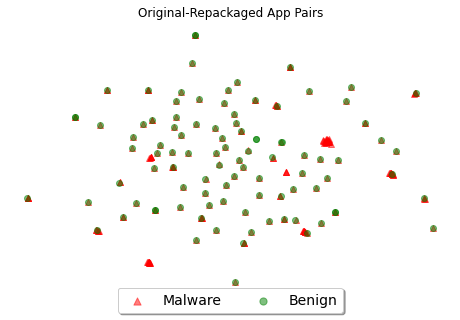

In [18]:
plt.subplots(figsize=(8,5))
plt.axis('off')
plt.scatter(sample1[sample1['label']==1]['x1'], sample1[sample1['label']==1]['x2'], 
            marker ='^', c='red', alpha=0.5)
plt.scatter(sample1[sample1['label']==0]['x1'], sample1[sample1['label']==0]['x2'],
            marker = 'o', c='green',alpha=0.5)
plt.legend(['Malware','Benign'], loc='upper center', bbox_to_anchor=(0.5, 0.05),
          fancybox=True, shadow=True, ncol=5, markerscale=1.2, 
          fontsize=14)
#plt.savefig("safe_learning.png")
plt.title("Original-Repackaged App Pairs")
plt.show()

In [19]:
# sample apps without its original/repackaged counterpart
s2 = data[~(data['SHA256'].isin(sample_pairs['SHA256_ORIGINAL']))&
      (~(data['SHA256'].isin(sample_pairs['SHA256_REPACKAGE'])))]
sample2 = s2.sample(n=297, random_state=100)
sample2.shape

(297, 354)

In [20]:
u = umap.UMAP(metric="jaccard", n_neighbors=2, min_dist=0.1)\
.fit_transform(sample2.drop(columns=['SHA256','label']))
u.shape

/Users/duanyueyun/miniconda3/lib/python3.7/site-packages/umap/umap_.py:1530: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


(297, 2)

In [21]:
sample2['x1'] = u[:,0]
sample2['x2'] = u[:,1]

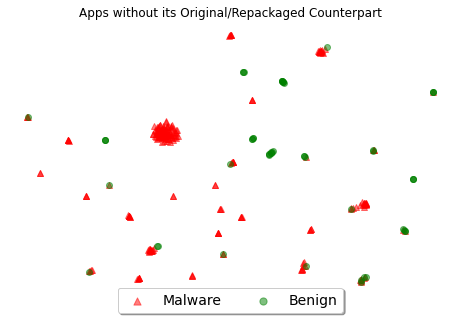

In [22]:
plt.subplots(figsize=(8,5))
plt.axis('off')
plt.scatter(sample2[sample2['label']==1]['x1'], sample2[sample2['label']==1]['x2'], 
            marker ='^', c='red', alpha=0.5)
plt.scatter(sample2[sample2['label']==0]['x1'], sample2[sample2['label']==0]['x2'],
            marker = 'o', c='green',alpha=0.5)
plt.legend(['Malware','Benign'], loc='upper center', bbox_to_anchor=(0.5, 0.05),
          fancybox=True, shadow=True, ncol=5, markerscale=1.2, 
          fontsize=14)
plt.title("Apps without its Original/Repackaged Counterpart")
#plt.savefig("safe_learning.png")
plt.show()